In [1]:
from qiskit.quantum_info import Statevector, Operator
from resources.star_battle import *
from resources.tally import *
from resources.basic_checker import *
from resources.grover import *
import numpy as np
import matplotlib.pyplot as plt

## a) Introduction - Star Battle Puzzles
[Star battle puzzles](https://www.puzzle-star-battle.com/) are grid-based puzzles somewhat similar to [jigsaw sudoku](https://www.sudopedia.org/wiki/Jigsaw_Sudoku). The given starting point is an $n\times n$ grid divided into $n$ orthogonally-connected regions and a number $k$, and the objective is to place stars in exactly $k n$ cells such that there are $k$ stars in each row, column, and region, and no stars are (even diagonally) adjacent. Here is an example of a $(n=5, k=1)$ star battle puzzle as given, a partial solution, and the final solution:

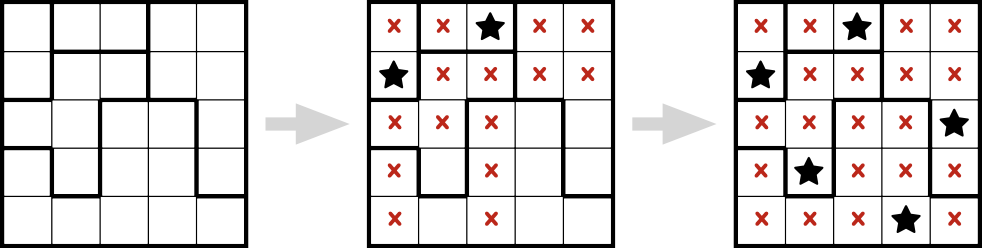

([puzzle id 8710731 at www.puzzle-star-battle.com](https://www.puzzle-star-battle.com/?pl=1b84471c3b38374fb3733006f754af3f683caf7a19e93))

Note that once a star's position is known, it rules out many of the potential positions for the other stars, as indicated by the red crosses.

## b) Approach for a (Simple) Grover Solver
The basic approach here is to assign a qubit to each cell (up to $n^2$ qubits for a $n\times n$ puzzle), and have the marker circuit act on the quantum state if the solution qubits satisfy each of the row, column, region, and adjacency constraints.

__Encoding constraints:__ The row, column and region constraints are all such that, amongst certain subsets of the cells, exactly $k$ members of the subset contain a star. I.e. there will be various subsets of solution qubits such that exactly $k$ in each subset must be $\left|1\right>$. The anti-adjacency constraint can be cast in a similar form: it is sufficient to require every $2\times 2$ region contain at most $1$ star. An $n\times n$ puzzle thus yields $3n+(n-1)^2 = n^2+n+1$ constraints, each restricting the number of $\left|1\right>$'s amongst a certain subset of the solution qubits.

__Marking approach:__ We will apply a custom Tally gate to each of the subsets to tally the number of $\left|1\right>$'s in that subset, and use basic logic to flip a separate 'constraint' qubit if the tally is valid. Beyond the solution qubits, there will be one additional qubit per constraint, and the Tally gates require a number of ancilla qubits equal to the size of the subset plus $1$.

__Simplifying the puzzle - known stars:__ In the following implementation of a Grover star battle solver, the number of qubits / dimension of the Hilbert space becomes a limitation very quickly. With the (admittedly simplistic and inefficient) approach implemented here, even the smallest viable star battle puzzle -  that is, a $(5,1)$ puzzle - requires at least
- $25$ solution qubits
- $5^2+5+1 = 31$ qubits to record whether constraints are satisfied
- $6$ ancilla qubits for tallying

or $62$ total qubits. So, while the demarked regions are typically the only givens for these puzzles, we here allow for the input to the Grover solver to be a partially solved puzzle. That is, besides the regions, we can also take as input the location of some known stars. And, in preprocessing, we rule out potential locations of new stars based on that of the known stars. For some $(5,1)$ puzzles with $2$ known stars, this leaves a small enough Hilbert space such that the circuit can be simulated on a personal (classical) computer.

## c) Preprocessing - from Puzzle to Constraints
Here we use a custom python class, Star_Battle, to do the classical preprocessing of the puzzles. (See resources/star_battle.py for the implementation.) A puzzle is specified by an $n\times n$ array, where each element is an integer in $[0,n)$. These integers indicate membership of each cell to a region.

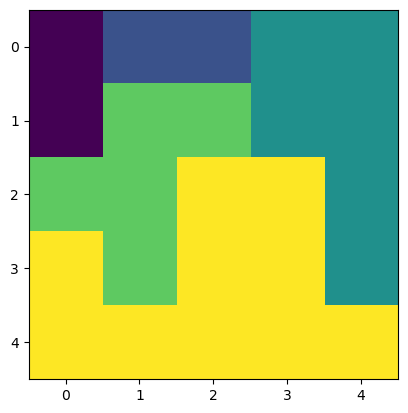

In [2]:
region_array = np.array([[0,1,1,2,2],[0,3,3,2,2],[3,3,4,4,2],[4,3,4,4,2],[4,4,4,4,4]])
sb = Star_Battle(region_array.shape[0], region_array)
sb.show_puzzle_grid()

We allow for some stars to be marked before the puzzle is passed to the quantum solver. For $k=1$ puzzles, the rows, columns, and regions of known stars are ruled out as possible locations for the remaining stars. The (up to 8 cells in the) neighborhood of the known stars are also ruled out. The locations ruled out by the two stars are marked by red X's below:

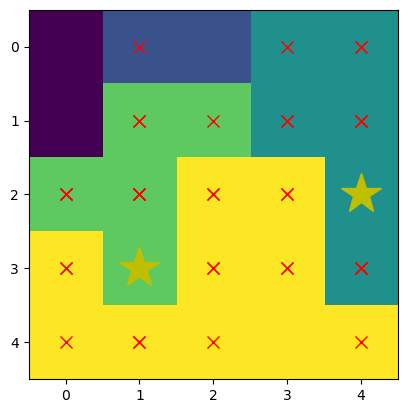

In [3]:
sb.set_known_stars([(3,1),(2,4)])
sb.show_puzzle_grid()

The remaining, open cells are possible locations for the remaining stars. There will be one 'solution' qubit for each of these cells. The constraints on the numbers of stars ($\left|1\right>$'s) amongst the open cells (solution qubits) is the essential information about the puzzle to be encoded into the marker circuit.

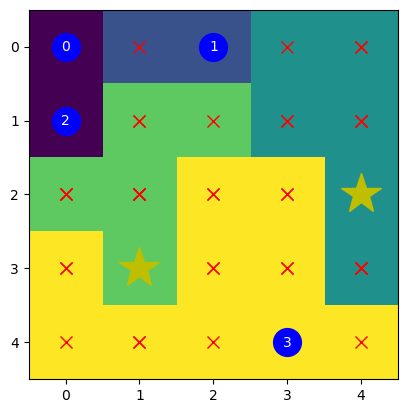

constraints:
  cells        0, 2      must collectively contain    1     star(s)
   ...         0, 1                 ...               1       ...  
   ...           1                  ...               1       ...  
   ...           2                  ...               1       ...  
   ...         0, 2                 ...              <=1      ...  
   ...           3                  ...               1       ...  


In [4]:
sb.show_puzzle_grid(display_unknowns=True)
sb.print_constraints()
num_solution_qubits, constraints = sb.get_constraints()

## d) Building Blocks of the Marker Circuit
This section demonstrates how to construct a marker/oracle circuit that will mark (i.e. negate the amplitude of) the solution state that satisfies all the puzzle constraints. We proceed by building the smallest elements and successively combine them to eventually form the full circuit.
### d.i) Tally Gate
__Description:__ A custom gate that operates on $n$ 'input' qubits and $n+1$ 'output' qubits with the following classical interpretation: assuming the ancilla qubits are each initially $\left|0\right>$, the kth ancilla qubit is set to $\left|1\right>$ (and all others set to $\left|0\right>$) if exactly k of the input qubits are $\left|1\right>$.

__Summary explanation:__ sets the 0th output qubit to $\left|1\right>$ as a 'flag' to indicate a starting tally of $0$. Then, for each input qubit, uses CCX gates to propgate the flag to higher output qubits if the input qubit is $\left|1\right>$. For more details, see the full definition in resources/tally.py.

__Complexity:__ Uses one X gate and $n(n+1)$ CCX gates.

__Example:__ Here is a test circuit that applies the gate to the input $\left|x\right> = \left|101_2\right>$.

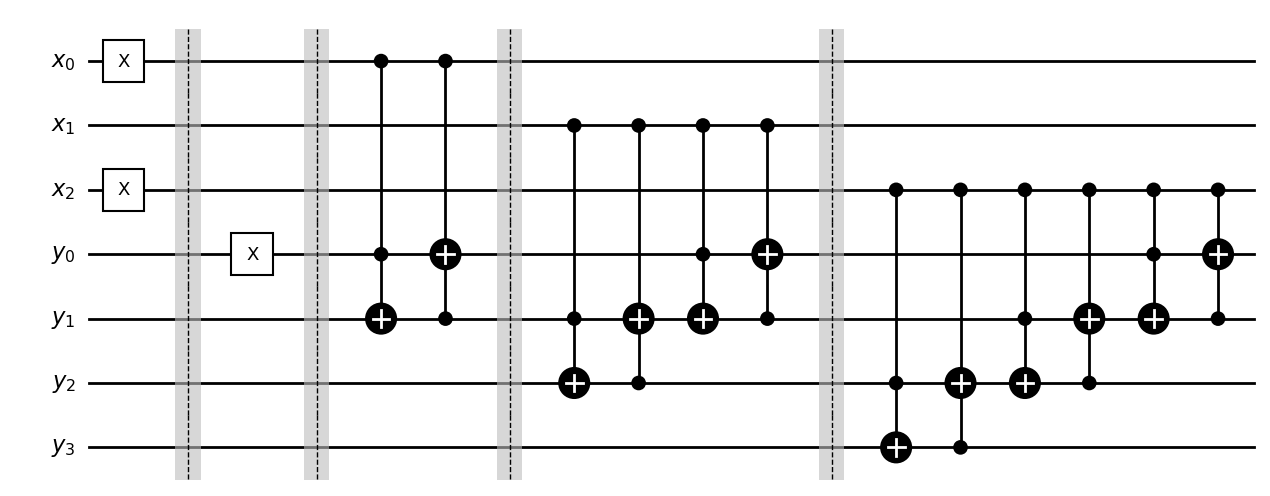

In [5]:
_,_,tally_circuit,_ = get_tally_gate(3)

x = QuantumRegister(3, name='x')
y = QuantumRegister(4, name='y')
test_qc = QuantumCircuit(x, y)
test_qc.x(x[[0,2]])
test_qc.barrier()
test_qc.compose(tally_circuit, inplace=True)

test_qc.draw(output='mpl', style='bw')

Note that $\left|y\right> = \left|0100_2\right>$, which indicates a tally of $2$, since the 'flag' is in position $2$:

In [6]:
Statevector(test_qc).draw('Latex')

<IPython.core.display.Latex object>

### d.ii) Tally-Controlled X Circuits
__Description:__ A circuit that operates on $n$ 'input' qubits, $n+1$ ancilla qubits for tallying, and one 'output'/controlled qubit, which applies X to the controlled qubit if the number of $1$'s amongst the input qubits matches the desired tally. This implementation is limited to either a single desired tally (given as an integer) or the indication that tallies of at most 1 are valid (given as the string '<=1').

__Summary explanation:__ uses a Tally gate to produce the tally flag on the ancilla. Then uses either CX gate or a combination of X and CCX gates to flip the output qubit if the tally is correct. Finally 'un-computes' the ancilla using the inverse of the Tally gate. For more details, see the full definition in resources/tally.py.

__Complexity:__ Uses one tally gate, one inverse tally gate, and either one CX gate if the given tally is an integer or five X gates and one CCX gate if the valid tally is '<=1'. In total: two X gate, one CX gate, and $2n^2+2n$ CCX gates or seven X gates and $2n^2+2n+1$ CCX gates, respectively.

__Example:__ a Tally-Controlled X applied to $\left|y\right>$ for a desired tally of '$\le1$'. 

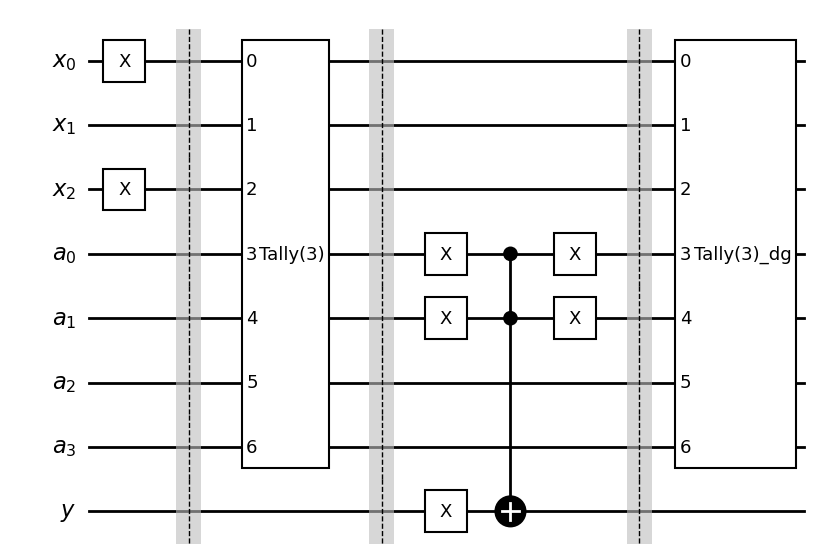

In [7]:
_,_,tallyCX_circuit,_ = get_tally_controlled_X_gate(3, '<=1')

x = QuantumRegister(3, name='x')
a = AncillaRegister(4, name='a')
y = AncillaRegister(1, name='y')
test_qc = QuantumCircuit(x, a, y)
test_qc.x(x[[0,2]])
test_qc.barrier()
test_qc.compose(tallyCX_circuit, inplace=True)

test_qc.draw(output='mpl', style='bw')

The output qubit is not flipped since more than one of the inputs is $\left|1\right>$:

In [8]:
Statevector(test_qc).draw('Latex')

<IPython.core.display.Latex object>

When only one of the input qubits is $\left|1\right>$, the output qubit is flipped:

In [9]:
test_qc = QuantumCircuit(x, a, y)
test_qc.x(x[2])
test_qc.barrier()
test_qc.compose(tallyCX_circuit, inplace=True)
Statevector(test_qc).draw('Latex')

<IPython.core.display.Latex object>

### d.iii) The 'Checker' Circuit
In order to check all the constraints produced by the classical preprocessing step, we simply compose Tally-Controlled X circuits, one for each constraint. Each circuit acts on the subset of solution qubits subject to the constraint, and each circuit controls it's own output qubit. For a valid solution to the star battle puzzle, all output qubits will be set to $\left|1\right>$. All the circuits use the same common set of tally qubits, which are left un-computed by each Tally-Controlled X circuit.

__Time Complexity:__ The number of gates used in this circuit depend on the details of the constraints, and therefore there is no simple close-form expression mapping, say, the size of the puzzle $n$ to the exact number of gates. (However, see section __(f)__, _Worst-Case Complexity_, below for a worst-case analysis across all puzzles of a given size.)

The number of X and CX gates depend on the number of each type of constraint. Suppose there are $C_1$ equality constraints, i.e. those where the tally should be a precise integer, and $C_2$ where the tally should be '$\le 1$'. The checker circuit requires $2C_1+7C_2$ X gates and $C_1$ CX gates. But the number of CCX gates also depend on the number of solution qubits involved in each constraint:
$$\mathrm{\#\;of\;CCX\;gates} = \sum_{c=1}^{C_1} (2m_{=,c}^2+2m_{=,c}) + \sum_{c=1}^{C_1} (2m_{\mathrm{\le 1},c}^2+2m_{\mathrm{\le 1},c}+1),$$
where $m_{=,c}$ is the number of solution qubits involved in the $c^\mathrm{th}$ equality constraint and $m_{\mathrm{\le 1},c}$ is the same for constraints of the inequality type.

Here is the calculation for the example puzzle above:

In [10]:
num_constraints = len(constraints)
C2 = len([con for con in constraints if con[1]=='<=1'])
C1 = num_constraints - C2
print(f"{'number of X gates required: ':>35}{2*C1+7*C2:>5}")
print(f"{'number of CX gates required: ':>35}{C1:>5}")
num_CCX = 0
for inds,tally in constraints:
    m = len(inds)
    num_CCX += 2*m**2 + 2*m
    if tally == '<=1':
        num_CCX += 1
print(f"{'number of CCX gates required: ':>35}{num_CCX:>5}")
print(''.join(['-' for i in range(40)]))
print(f"{'total number of gates required: ':>35}{3*C1+7*C2+num_CCX:>5}")

       number of X gates required:    17
      number of CX gates required:     5
     number of CCX gates required:    49
----------------------------------------
   total number of gates required:    71


__Space Complexity:__ In terms of circuit width, the number of output qubits is equal to the number of constraints, and the number of tally qubits required is one more than the largest number of solution qubits in any constraint. So the total number of qubits is equal to one plus the sum of
- the number of unknown cells / solution qubits
- the number of constraints
- the size of the largest subset of unknown cells that appear in a constraint

The example puzzle above requires 13 qubits to be solved via this approach:

In [11]:
print(f"{'number of solution qubits required: ':>40}{num_solution_qubits:>5}")
print(f"{'number of constraint qubits required: ':>40}{num_constraints:>5}")
max_subset_size = max([len(inds) for inds,tally in constraints])
print(f"{'number of tally qubits required: ':>40}{max_subset_size + 1:>5}")
print(''.join(['-' for i in range(45)]))
print(f"{'total number of qubits required: ':>40}{num_solution_qubits + num_constraints + max_subset_size + 1:>5}")

    number of solution qubits required:     4
  number of constraint qubits required:     6
       number of tally qubits required:     3
---------------------------------------------
       total number of qubits required:    13


__Example Circuit:__ The following shows the translation of the list of constraints from the puzzle above into the composed Tally-Controlled X circuits acting on those 13 qubits.

constraints:
  cells        0, 2      must collectively contain    1     star(s)
   ...         0, 1                 ...               1       ...  
   ...           1                  ...               1       ...  
   ...           2                  ...               1       ...  
   ...         0, 2                 ...              <=1      ...  
   ...           3                  ...               1       ...  


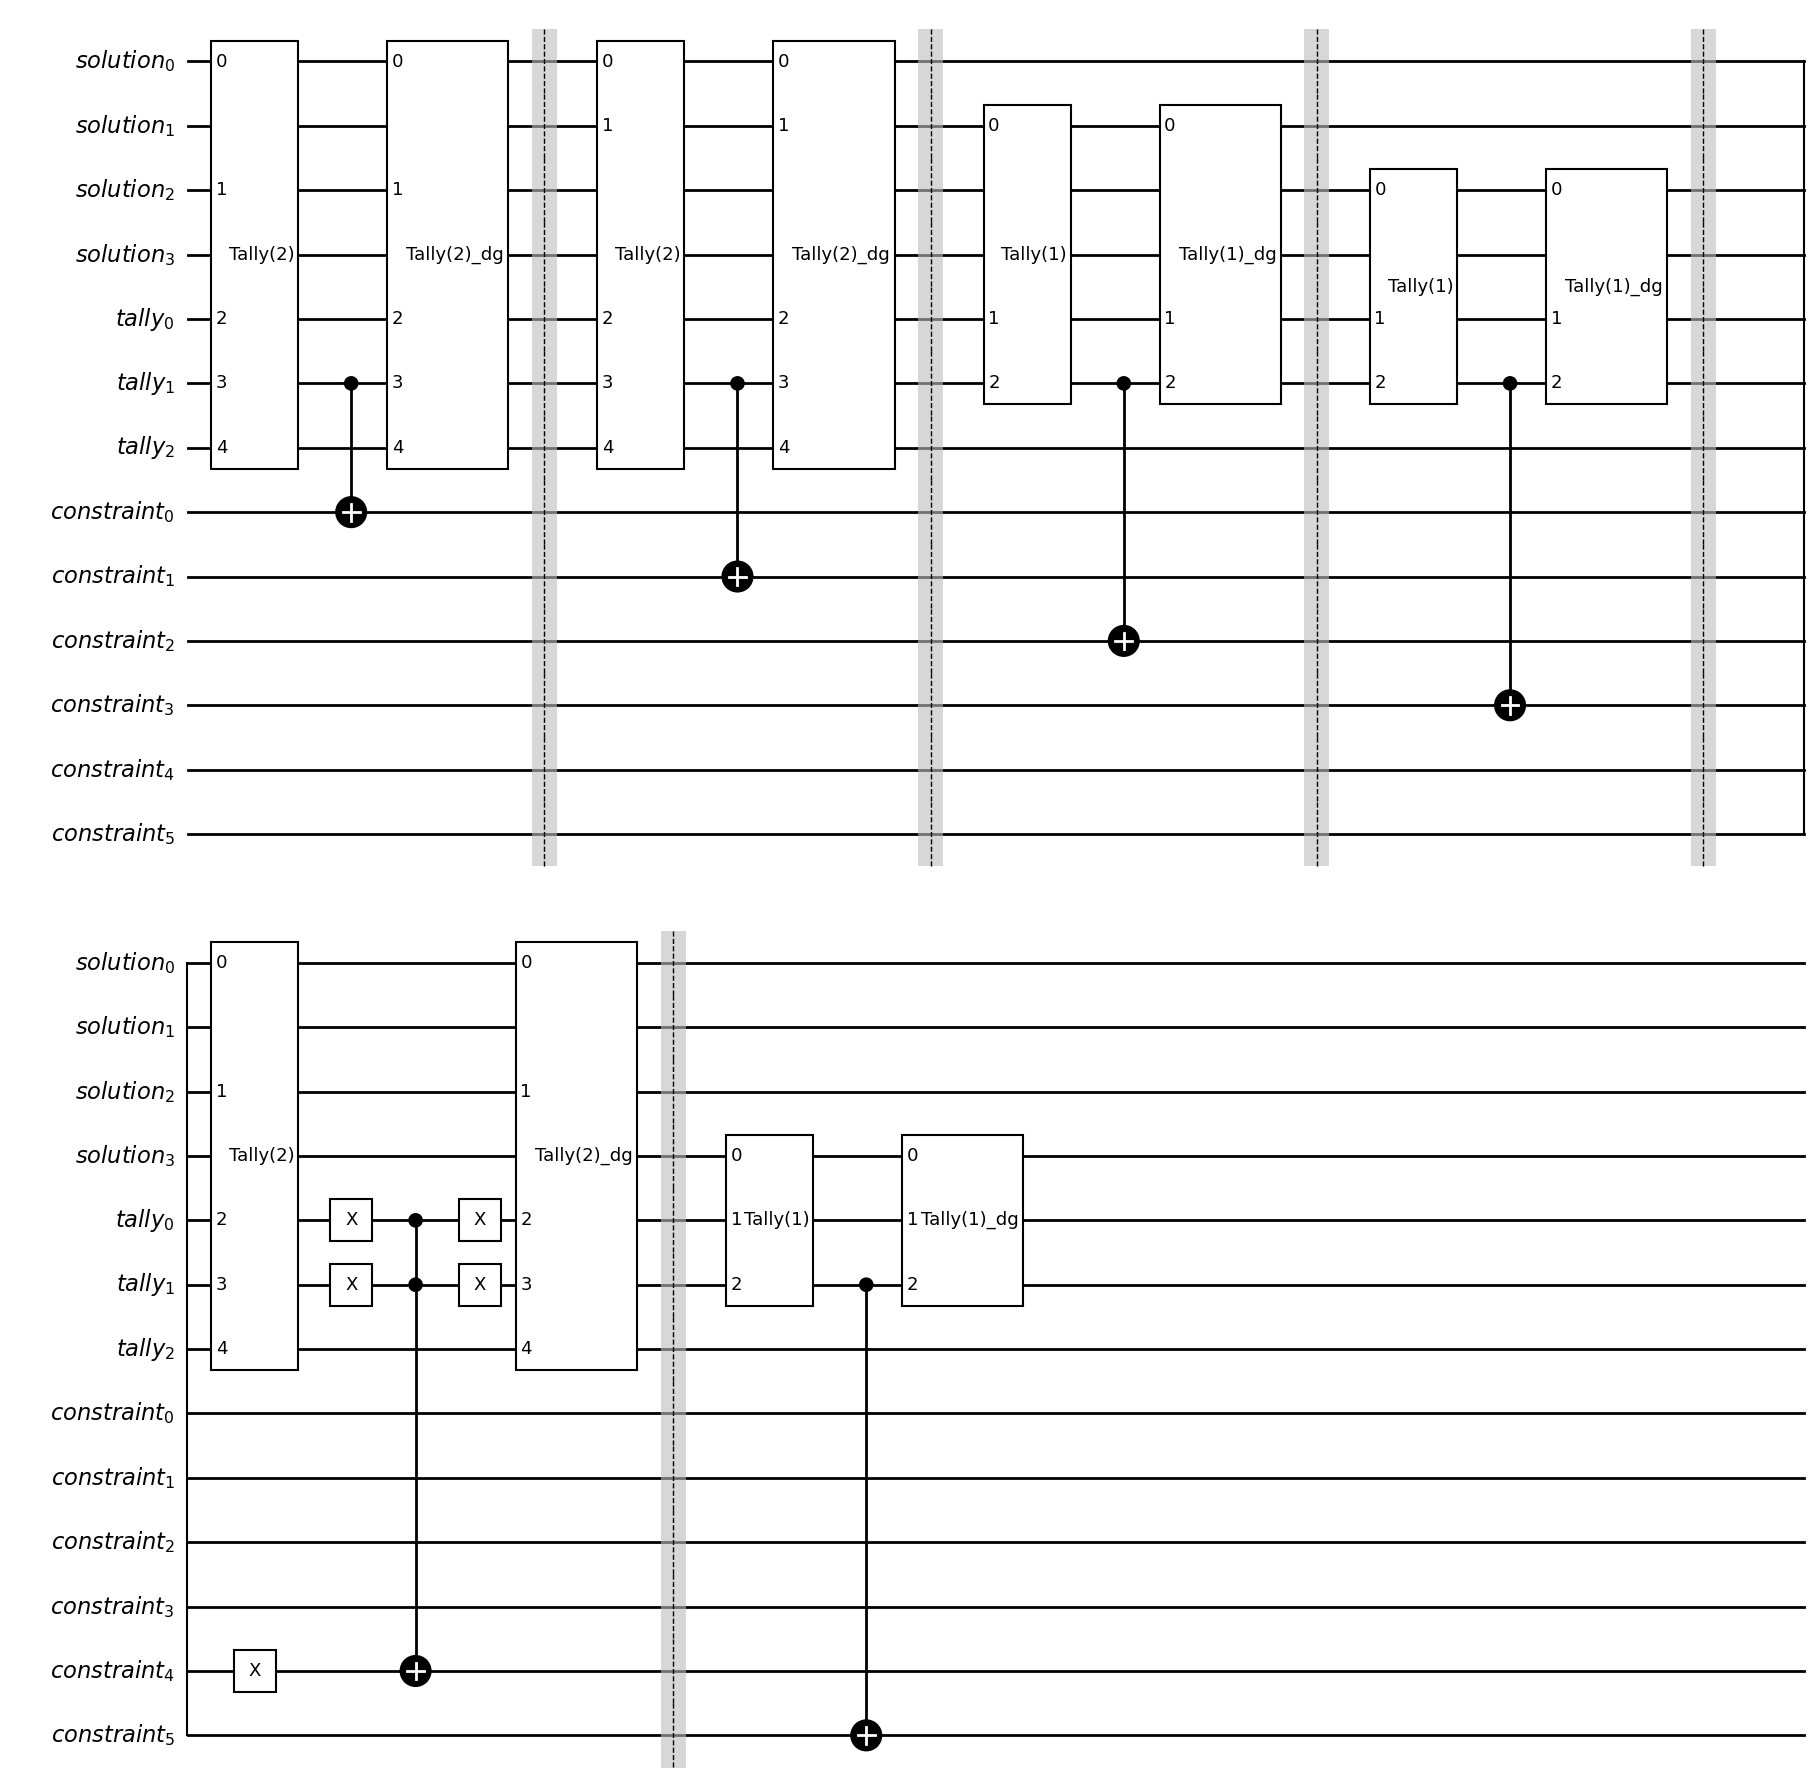

In [12]:
sb.print_constraints()

x = QuantumRegister(size=num_solution_qubits, name='solution')
t = AncillaRegister(size=max_subset_size + 1, name='tally')
c = AncillaRegister(size=num_constraints, name='constraint')

# circuit that sets the constraint qubits based on the solution qubits
check_constraints_qc = QuantumCircuit(x, t, c, name='Check Constraints')

for k, (inds, tally) in enumerate(constraints): # loop over contraints
    if k != 0:
        check_constraints_qc.barrier()
    # ... and add a Tally-Controlled X circuit for each one
    _,_,tallyCX_circuit,_ = get_tally_controlled_X_gate(len(inds), tally)
    check_constraints_qc.compose(RemoveBarriers()(tallyCX_circuit), qubits = x[inds] + t[0:len(inds)+1] + [c[k]], inplace=True)

check_constraints_qc.draw(output='mpl', style='bw')

### d.iv) The Marker Block

The full marker block for each iteration of Grover's algorithm composes the above checker circuit with a multi-controlled Z across all the constraint qubits and then the inverse of the checker circuit. This leaves the constraint qubits 'un-computed' but negates the amplitude of the correct solution state. It uses double the number of gates of each type as the checker circuit plus the multi-controlled Z.

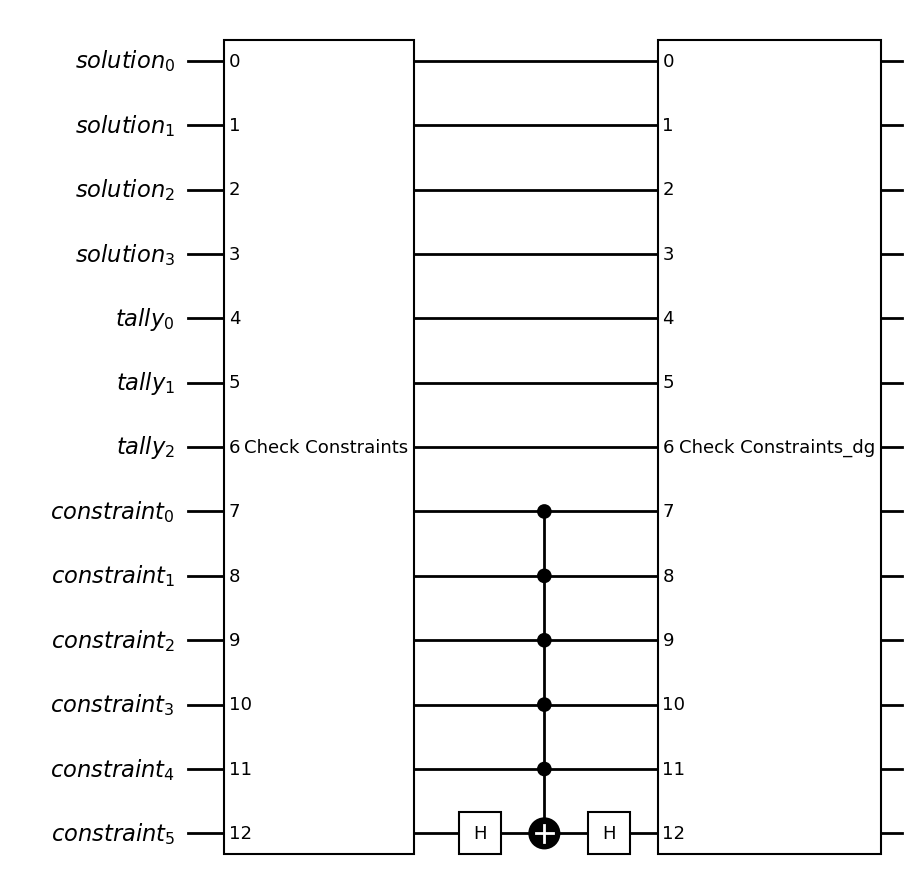

In [13]:
check_constraints_gate = RemoveBarriers()(check_constraints_qc).to_gate()

marker_qc = QuantumCircuit(x, t, c, name='Marker')
marker_qc.compose(check_constraints_gate, inplace=True)
marker_qc.h(c[-1])
marker_qc.mcx(c[:-1], c[-1])
marker_qc.h(c[-1]) # these three lines: effectively a multi-controlled Z gate
marker_qc.compose(check_constraints_gate.inverse(), inplace=True)

marker_qc.draw(output='mpl', style='bw')

## e) Grover's Solution
### e.i) ... for the example puzzle above

For the search space of size $2^4$, three Grover iterations are required:

In [14]:
iterations = int(np.rint(np.pi / (4 * np.arcsin(1 / np.sqrt(2**len(x)))) - 1/2))
print('number of Grover iterations required:', iterations)

number of Grover iterations required: 3


Now we just build the standard Grover circuit with that many iterations and print out the measurement probabilities:

In [15]:
# enclose marker circuit into a gate
marker_gate = RemoveBarriers()(marker_qc).to_gate()

# define the diffusion block
diffuser_qc = QuantumCircuit(x, name="Diffuser")
diffuser_qc.h(x)
diffuser_qc.x(x)
diffuser_qc.h(x[-1])
diffuser_qc.mcx(x[:-1], x[-1])
diffuser_qc.h(x[-1]) # these three lines: effectively a multi-controlled Z gate
diffuser_qc.x(x)
diffuser_qc.h(x)
diffuser_gate = diffuser_qc.to_gate()

# full circuit
grover_qc = QuantumCircuit(x,t,c)
grover_qc.h(x)
for i in range(iterations):
    grover_qc.compose(marker_gate, inplace=True)
    grover_qc.compose(diffuser_gate, inplace=True)

# get top measurement probabilities
probs = Statevector(grover_qc).probabilities_dict(decimals=6)

# trim statevector to only show x qubits
probs = {str(state)[-num_solution_qubits:]:p for state, p in probs.items()}
print_probabilities(probs)

                    probability         
solution state      of measurement      
----------------------------------------
|0000>              0.002579
|0001>              0.002579
|0010>              0.002579
|0011>              0.002579
|0100>              0.002579
|0101>              0.002579
|0110>              0.002579
|0111>              0.002579
|1000>              0.002579
|1001>              0.002579
|1010>              0.002579
|1011>              0.002579
|1100>              0.002579
|1101>              0.002579
|1110>              0.961319  <---
|1111>              0.002579


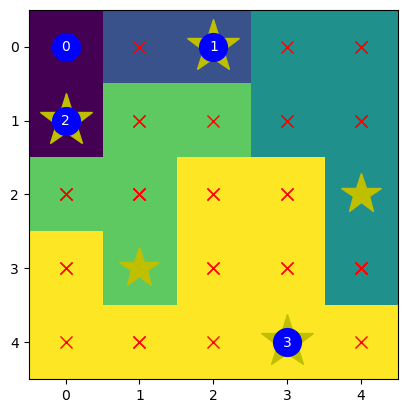

In [16]:
sb.set_solution_stars([1,2,3])
sb.show_puzzle_grid(display_unknowns=True)

For this puzzle, Grover's algorithm would identify the correct solution ($\left|x\right> = \left|1110_2\right>$) with $96.1\%$ probability. This implementation uses $13$ total qubits ($4$ primary and $9$ ancilla). The inital state preparation uses $4$ H gates, and the $3$ copies of the diffuser block together use $24$ H gates, $24$ X gates, and $3$ multi-controlled Z gates. The $3$ marker blocks, which each contain a copy of the checker circuit, it's inverse, and a multi-controlled Z gate, together contain $102$ X gates, $30$ CX gates, $294$ CCX gates, and $3$ multi-controlled Z gates. In all, this circuit requires:
- $28$ H gates
- $126$ X gates
- $30$ CX gates
- $294$ CCX gates
- $6$ multi-controlled Z gates
  
for a grand total of $484$ gates.

### e.ii) ... for another example
([puzzle id 1051344](https://www.puzzle-star-battle.com/?pl=1483c17077f97083ecb4e0a345f1e946683d1d683461a))

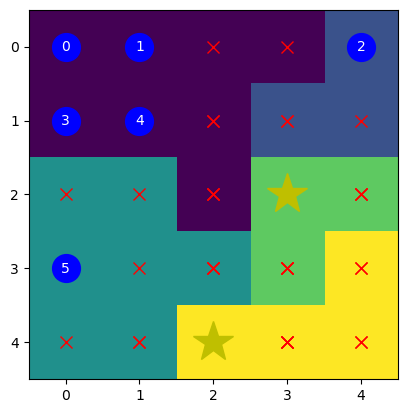

constraints:
  cells        3, 4      must collectively contain    1     star(s)
   ...         3, 4                 ...              <=1      ...  
   ...      0, 1, 3, 4              ...              <=1      ...  
   ...           2                  ...               1       ...  
   ...         1, 4                 ...               1       ...  
   ...      0, 1, 3, 4              ...               1       ...  
   ...        0, 3, 5               ...               1       ...  
   ...           5                  ...               1       ...  
   ...         1, 4                 ...              <=1      ...  
   ...        0, 1, 2               ...               1       ...  


In [17]:
# classical preprocessing
region_array = np.array([[0,0,0,0,1],[0,0,0,1,1],[2,2,0,3,3],[2,2,2,3,4],[2,2,4,4,4]])
sb2 = Star_Battle(region_array.shape[0], region_array)
sb2.set_known_stars([(4,2),(2,3)])
sb2.show_puzzle_grid(display_unknowns=True)
sb2.print_constraints()

Here we make use of the functions basic_checker (defined in resources/basic_checker.py) and grover_from_checker (defined in resources/grover.py), which encapsulate much of the rote calculation and code written out for the first example above. basic_checker takes in a list a contraints as produced by the preprocessing step and returns a checker gate (i.e, a gate whose action is to flip constraint qubits if the corresponding constraints are satisfied). grover_from_checker takes such a checker gate, turns that gate in to full marker block, produces and runs the full Grover circuit with the appropriate number of iterations, and returns the probabilities dictionary.

In [18]:
# generate checker circuit from constraints
num_solution_qubits, constraints = sb2.get_constraints()
check_constraints_gate, num_qubits, _, checker_gates_dict = basic_checker(num_solution_qubits, constraints)
print_circuit_width(num_qubits)
print()
print('Gates in checker circuit:')
print_number_of_gates(checker_gates_dict)
print()

# generate and run full Grover circuit
probs, iterations, gates_dict = grover_from_checker(check_constraints_gate, num_qubits, checker_gates_dict)

print('number of iterations required:', iterations)
print()

print('Gates in full Grover circuit:')
print_number_of_gates(gates_dict)
print()
print_probabilities(probs)

    number of solution qubits required:     6
     number of ancilla qubits required:     5
  number of constraint qubits required:    10
---------------------------------------------
       total number of qubits required:    21

Gates in checker circuit:
            number of X gates required:    35
           number of CX gates required:     7
          number of CCX gates required:   187
---------------------------------------------
        total number of gates required:   229

number of iterations required: 6

Gates in full Grover circuit:
            number of X gates required:   492
           number of CX gates required:    84
          number of CCX gates required:  2244
            number of H gates required:    78
          number of MCZ gates required:    12
---------------------------------------------
        total number of gates required:  2910

                    probability         
solution state      of measurement      
----------------------------------------
|0

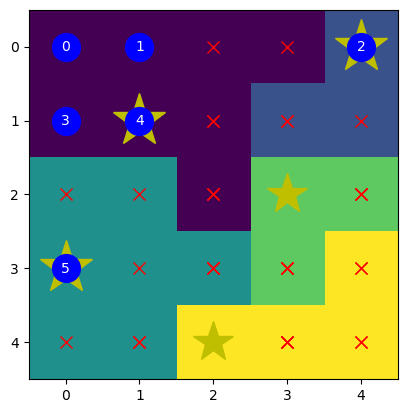

In [19]:
sb2.set_solution_stars([2,4,5])
sb2.show_puzzle_grid(display_unknowns=True)

Grover's algorithm finds the correct solution with $99.7\%$ probability.

## f) Worst-Case Complexity
#### f.i) The number of gates and qubits required in the checker circuit for a $n \times n$ puzzle with no known stars

As discussed in __(b)__, the cells in an $n \times n$ puzzle with no known stars are subject to $n^2+n+1$ constraints. Of those,
- $2n$ are equality constraints over $n$ cells each - the row and column constraints
- $n$ are equality constraints over a puzzle-dependent numbers of cells, $r_i$ - the region constraints
- $(n-1)^2$ are inequality constraints over $4$ cells each - the anti-adjacency constraints

$r_i$ are the number of cells in each region. It must be that $\sum_{0}^{n-1} r_i = n^2$, but otherwise we know little about the individual $r_i$.

##### Time Complexity
From the analysis in __(d.iii)__, the checker circuit requires $7n^2-8n+7$ X gates, $3n$ CX gates, and 
$$4n^3 + 47n^2-82n+41 + 2 \sum_{i=0}^{n-1} r_i^2$$
CCX gates.

##### Space Complexity
From __(d.iii)__, the checker circuit requires $2n^2+n+2 + \max_i r_i$ qubits.

#### f.ii) Bounds and asymptotic complexity for the checker circuit across all $n \times n$ puzzles
Note that
$$\sum_{i=0}^{n-1} r_i^2 < \left(\sum_{i=0}^{n-1} r_i\right)\left(\sum_{j=0}^{n-1} r_j\right)=n^4,$$
and so the checker circuit contains less than $2n^4 + 4n^3 + 47n^2-82n+41$ CCX gates. Separately, since the smallest possible region in a star battle puzzle is one cell large, the largest possible occurs in puzzles with $n-1$ one-cell regions. The largest possible region is therefore $n^2-n+1$ cells large. The number of required qubits is therefore (tightly) upper bounded by $3n^2+3$. Clearly, the total number of gates in the checker circuit is $\mathcal{O}(n^4)$ and the number of required qubits is $\mathcal{O}(n^2)$ as $n\rightarrow \infty$. 

Naturally, since known stars only decrease the number of unknown cells and constraints, the above bounds hold for puzzle with known stars, too. Though, it is not immeadiately clear how the asymptotic complexity might be reduced if the number of known stars scales with the puzzle size, for example.

#### f.iii) Asymptotic complexity for the full Grover circuit
The marker block has $2$ times the number of gates as the checker circuit plus $1$ multi-controlled Z gate. The diffuser block operates on the $n^2$ solution qubits and contains $\mathcal{O}(n^2)$ gates. Therefore the total worst-case asymptotic gate count for one iteration of Grover's algorithm is the same as that for the checker circuit: $\mathcal{O}(n^4)$. And since Grover's algorithm requires $\mathcal{O}(\sqrt{2^{n^2}})$ iterations, the full Grover circuit has a time complexity of $\mathcal{O}(n^4 2^{\frac{1}{2}n^2})$. Like the checker circuit alone, it has space complexity of $\mathcal{O}(n^2)$.

## g) Increasing Efficiency - Potential Future Steps 
The following are some ideas to increase the efficiency of the checker circuit as it was implemented above. If pursued, these approaches will be investigated in other notebooks in this repository.
### g.i) Optimizing for Width of the Circuit

#### - Order the Tally-Controlled X's and Mix the Use of Ancilla Qubits for Tallying and Constraint Marking
The tally qubits are uncomputed after each constraint is checked, and constraint qubits are set one at a time. So, tally qubits used early on could be used later in the circuit as constraint qubits, if the later tallies are smaller. This is likely (though, it is puzzle-dependent) to reduce the total number of ancilla qubits required. For the best possible chance to save on ancilla qubits, one can simply require the constraints to be checked in order of decreasing subset size. Notably, since this optimization simply reorders the Tally-Controlled X gates, it requires no additional gates as compared with implementation above. There is no trade-off here of circuit width for depth.


#### - Encode Tallies and Number of Constraints Satisfied as Binary Numbers
For larger puzzles or puzzles with one or more large regions, the subsets of solution qubits subject to certain constraints may be quite large, up to $\mathcal{O}(n^2)$ for a $n\times n$ puzzle. It may be worthwhile to represent the tally of $\left| 1 \right>$ qubits in the subset by a binary number, rather than a 'flag'. This would reduce the number of qubits required for the tallies from $m+1$ (for a maximum subset size of $m$) to $\lceil \log_2 (m+1) \rceil$. This would require 'controlled increment' gates, one controlled by each qubit in the subset.  One possibility for implementation would use a simplified version of a Draper adder, where one summand (the solution qubit) is assumed to be $\left| 0 \right>$ or $\left| 1 \right>$. After the increments, simple logic with X and MCX gates could be used to flip a constraint bit if the tally register holds the correct number in binary. 

One might similarly reduce the number of qubits required to represent constraints. Note that only the number of constraints satisfied matters; if any less than all are satisfied, it does not matter which are and which are not. So the $c$ constraint qubits could be replaced by a $\lceil \log_2 (c+1) \rceil$ qubit register that would hold the count in binary of the number of constraints satisied.

### g.ii) Optimizing for Depth of the Circuit
#### - Don't Uncompute Tallies for Equality Constraints
In the basic implementation of the checker circuit, one does not actually need to uncompute the tally after each equality constraint is checked, as long as the tally flag 'wraps-around' from it's highest position back to position $0$. (Essentially this would require a controlled cyclic permuation gate on the tally qubits, instead of the Tally gate discussed above.) If not uncomputing, one just needs to keep track of the accumulated offset in flag position after each constraint check, under the assumption the previous tallies satisfied the equality constraints. (One can make that assumption, because, if a previous tally did not, it's constraint qubit will be $\left| 0 \right>$, and the remainder of the check circuit computation will have no effect on marking.) Then one can accordingly adjust which qubit(s) flip the constraint qubits. 

This optimization would save nearly half of the gates associated with equality constraints and does not cost any additional ancilla. We already are using enough tally ancilla such that every tally will be uniquely interpretable, even with 'wrap-around' / overflow. This idea does, however, preclude the mixing of the tallying and constraint ancilla qubits (as in the first idea under __(g.i)__ above), since all tally qubits would be needed for tallying throughout the checker circuit. For simulating the circuit on a classical computer, the optimization of reducing the number of ancilla (however few) may be more impactful than reducing the number of gates.